In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


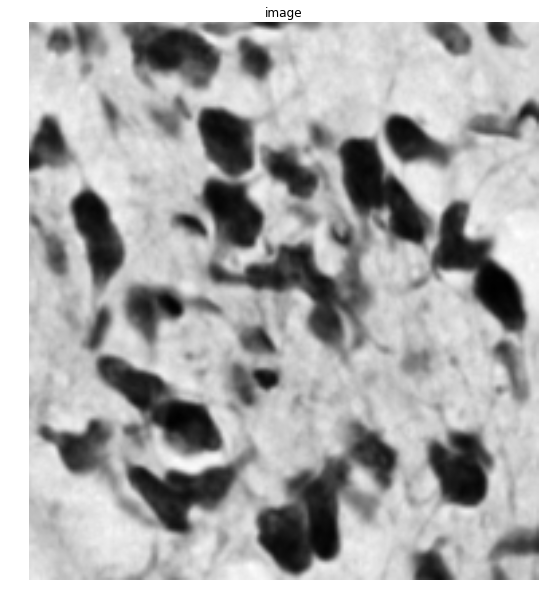

In [2]:
img = imread('/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD589_lossless_aligned_cropped_grayscale/MD589_0134_lossless_aligned_cropped_grayscale.tif')
im = img[7245:7245+208, 2845:2845+190]

plt.figure(figsize=(10,10));
plt.imshow(im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('image');

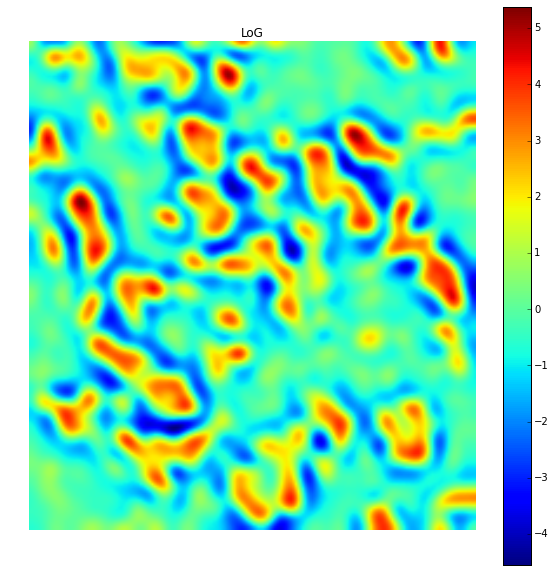

In [4]:
LoG = nd.gaussian_laplace(im.astype(np.float), 4)

plt.figure(figsize=(10,10));

plt.imshow(LoG);
plt.axis('off');
plt.title('LoG');
plt.colorbar();

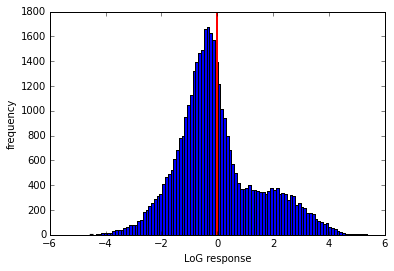

In [5]:
LoG_thres = 0.

plt.hist(LoG.flat, bins=100);
plt.gca().axvline(x=LoG_thres, c='r', linewidth=2);
plt.xlabel('LoG response');
plt.ylabel('frequency');

In [6]:
s3 = np.sign(LoG - LoG_thres)
s3[0,:] = 0
s3[-1,:] = 0
s3[:,0] = 0
s3[:,-1] = 0

s3[s3==0] = -1     # replace zeros with -1

diff_x = np.r_[np.zeros((1,im.shape[1]), np.bool), (np.diff(s3, axis=0) != 0)]
diff_y = np.c_[np.zeros((im.shape[0], 1), np.bool), (np.diff(s3, axis=1) != 0)]
           
zero_crossings3 = np.where(diff_x | diff_y)

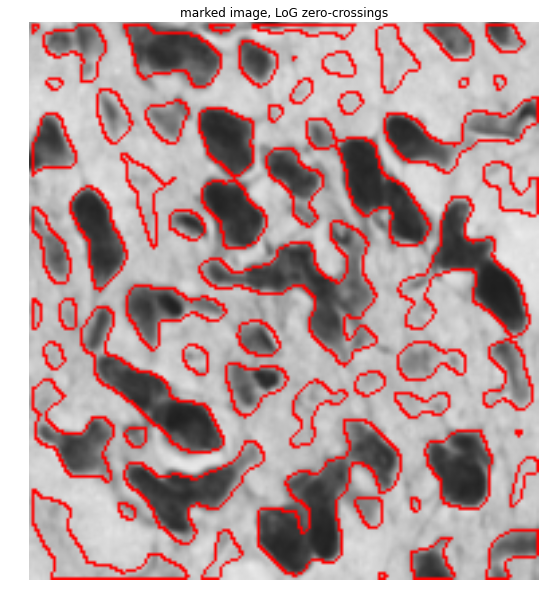

In [7]:
output = np.zeros_like(im, dtype=np.bool)
output[zero_crossings3] = True

plt.figure(figsize=(10,10));

marked_im = gray2rgb(im)
marked_im[output] = (255,0,0)

plt.figure(figsize=(10,10));
plt.imshow(marked_im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('marked image, LoG zero-crossings');

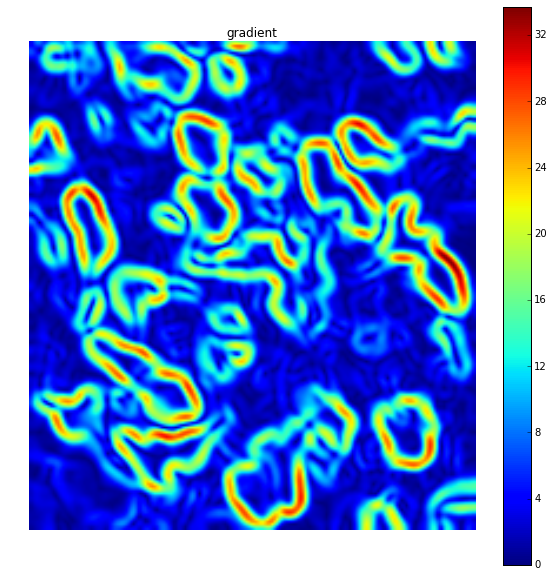

In [8]:
Gy, Gx = np.gradient(nd.gaussian_filter(im.astype(np.float), 2))
# Gy, Gx = np.gradient(im.astype(np.float))
G = np.sqrt(Gx**2+Gy**2)

plt.figure(figsize=(10,10));
plt.imshow(G);
plt.axis('off');
plt.title('gradient');
plt.colorbar();

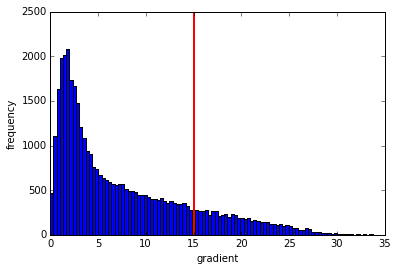

In [9]:
G_thresh = 15

plt.hist(G.flat, bins=100);
plt.gca().axvline(x=G_thresh, c='r', linewidth=2);
plt.xlabel('gradient');
plt.ylabel('frequency');

In [10]:
from scipy.ndimage import label
from skimage.morphology import square
from skimage.measure import regionprops

In [11]:
labeled, n_rings = label(output, square(3))
props = regionprops(labeled, G)
cell_mean_gradient = np.array([p.mean_intensity for p in props])

valid = np.where(cell_mean_gradient > 10)[0]

cell_contour_coords = np.array([p.coords for i, p in enumerate(props) if i in valid])
cell_bbox = np.array([p.bbox for i, p in enumerate(props) if i in valid])

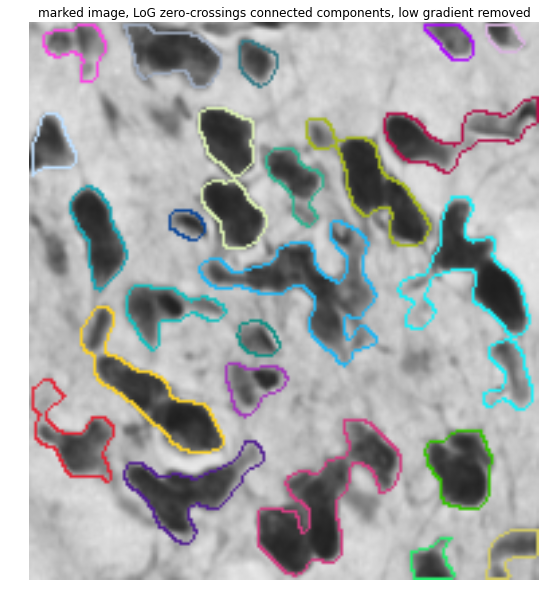

In [14]:
marked_im2 = gray2rgb(im)

for coords in cell_contour_coords:
    marked_im2[coords[:,0], coords[:,1]] = (np.random.random((3,)) * 255).astype(np.int)

plt.figure(figsize=(10,10));
plt.imshow(marked_im2);
plt.axis('off');
plt.title('marked image, LoG zero-crossings connected components, low gradient removed');

NameError: name 'valid_cell_coords' is not defined

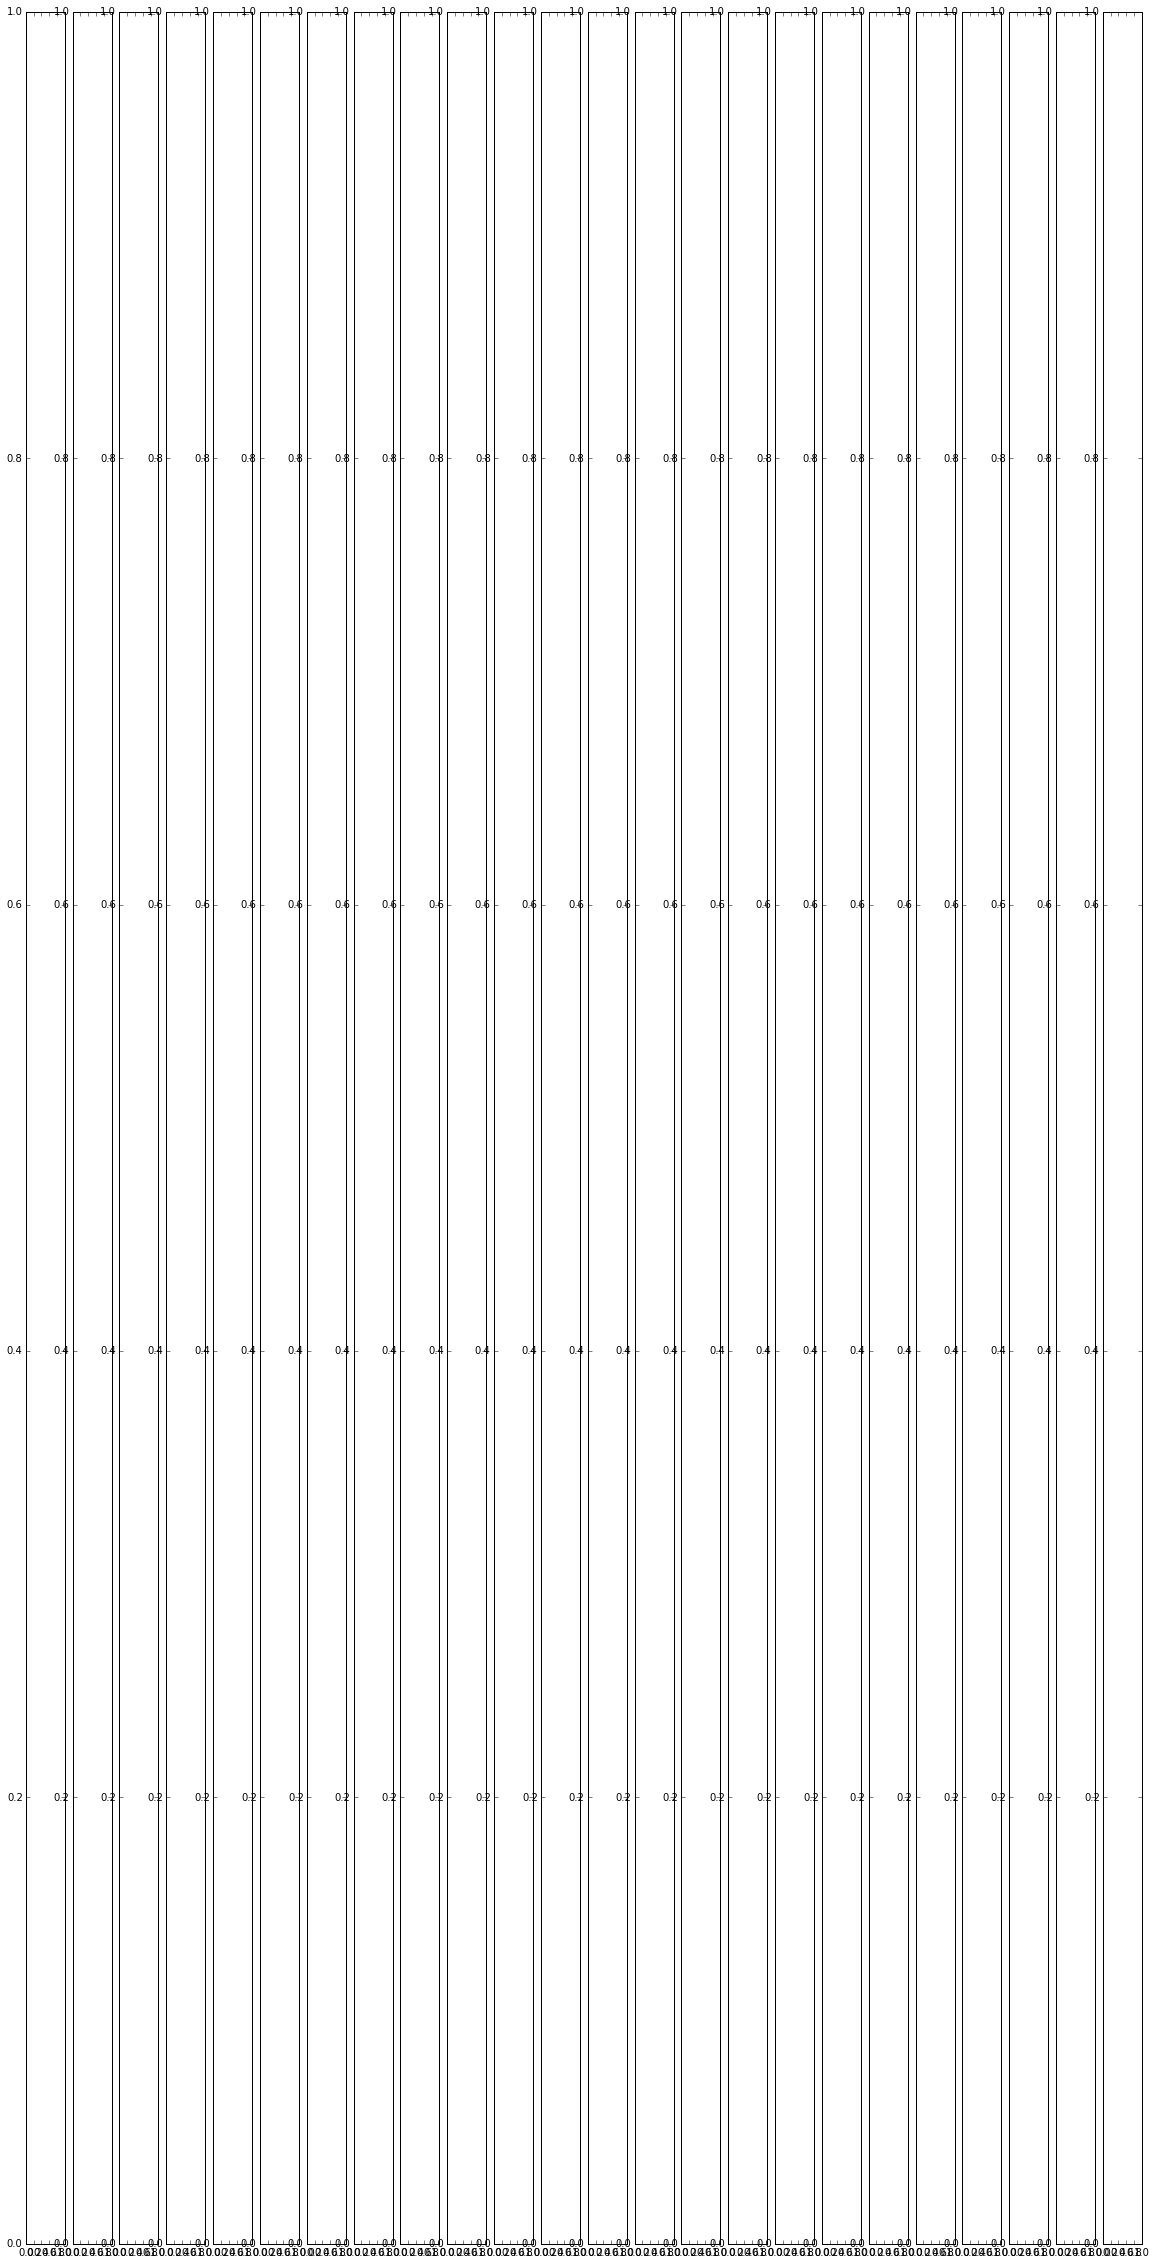

In [18]:
# the sizes of cells are artifically normalized.

n = len(cell_bbox)

fig, axes = plt.subplots(1, n, figsize=(20,40))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ymin, xmin, ymax, xmax = cell_bbox[i]
    cell_im = im[ymin:ymax+1, xmin:xmax+1].copy()
    
    h, w = cell_im.shape

    bbox = np.zeros((h, w))
    bbox[cell_coords[i][:,0]-ymin, cell_contour_coords[i][:,1]-xmin] = 1    
    cell_bbox_mask = nd.binary_fill_holes(bbox)
        
    cell_im[~cell_bbox_mask] = 255
    
    ax.imshow(cell_im, cmap=plt.cm.gray);
    
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        right='off',
        labelbottom='off',
        labelleft='off')
        